In [1]:
# seq2seq

In [213]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import CSVLogger

from tensorflow.keras import layers

In [ ]:
!curl -O http://ufldl.stanford.edu/housenumbers/train.tar.gz
!curl -O http://ufldl.stanford.edu/housenumbers/test.tar.gz
!mkdir data    
!tar -xf train.tar.gz -C ./data
!tar -xf test.tar.gz -C ./data

In [214]:
#import pdb; pdb.set_trace()

def loadData(filename,dataPath):
    with open(filename,'r') as csvfile:
        data=csvfile.read()
    data=data.split("\n")
    
    img=[]
    gt=[]
    for item in data:
        try:
            i =item.split(",")
            if(i[0]!=""):
                img.append(dataPath+i[0][1:])
                gt.append(i[1])
        except:
            print(i)
    return img,gt

In [215]:
dataPath = "/home/reza/newOCR/OCR/data"
images,labels=loadData("./train.csv",dataPath)



EOS = "\n"
SOS = "\t"


characters = set(char for label in labels for char in label)
characters.add(EOS)
characters.add(SOS)

characters=['\x01']+list(sorted(characters)) # \x01 for padding

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50
# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset


max_length = max([len(label) for label in labels])+2 # +2 is for SOS and EOS
num_characters=len(characters)


print(list(labels[0]))
for i in range(len(labels)):
    labels[i]=SOS+labels[i]+EOS+"".join(['\x01']*(max_length-2-len(labels[i])))# -2 is for SOS and EOS
print(list(labels[0]))






Number of images found:  33402
Number of labels found:  33402
Number of unique characters:  13
Characters present:  ['\x01', '\t', '\n', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['1', '9']
['\t', '1', '9', '\n', '\x01', '\x01', '\x01', '\x01']


In [216]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=characters, num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)#dataPath+img_path[1:]
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers

    
    decoder_input_data = tf.one_hot(char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8")), num_characters)
   
    
    decoder_target_data = tf.concat([decoder_input_data[1:],tf.one_hot([0],num_characters)],0)   
    

    return {"image": img, "decoder_inputs": decoder_input_data},decoder_target_data

In [67]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

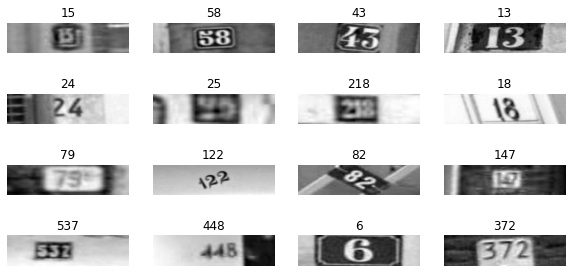

In [68]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch[0]["image"]
    labels = batch[0]["decoder_inputs"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(tf.argmax(labels[i], axis=1))).numpy().decode("utf-8")[1:].replace("\x01","").replace("\n","")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [77]:

def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    decoder_inputs = layers.Input(name="decoder_inputs", shape=(None, len(characters)), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    encoder_outputs, state_h, state_c  = layers.LSTM(128, return_sequences=True,
                                                                          return_state=True, dropout=0.25)(x)
    encoder_states = [state_h, state_c]
    decoder_outputs,_,_  = layers.LSTM(128, return_sequences=True,return_state=True,
                                                            dropout=0.25)(decoder_inputs,initial_state=encoder_states)

    # Output layer
    output = layers.Dense(
        len(char_to_num.get_vocabulary()) , activation="softmax", name="dense2" )(decoder_outputs)


    # Define the model
    model = keras.models.Model(
        inputs=[input_img, decoder_inputs], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [78]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
csv_logger = CSVLogger('log_v2.csv', append=True, separator=';')

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping,csv_logger],
)

Epoch 1/100
1879/1879 [==============================] - 24s 10ms/step - loss: 0.8604 - accuracy: 0.7225 - val_loss: 0.7304 - val_accuracy: 0.7606
Epoch 2/100
1879/1879 [==============================] - 18s 10ms/step - loss: 0.7524 - accuracy: 0.7507 - val_loss: 0.6960 - val_accuracy: 0.7702
Epoch 3/100
1879/1879 [==============================] - 18s 10ms/step - loss: 0.7165 - accuracy: 0.7605 - val_loss: 0.6630 - val_accuracy: 0.7852
Epoch 4/100
1879/1879 [==============================] - 18s 10ms/step - loss: 0.6694 - accuracy: 0.7801 - val_loss: 0.5933 - val_accuracy: 0.8057
Epoch 5/100
1879/1879 [==============================] - 18s 10ms/step - loss: 0.5882 - accuracy: 0.8080 - val_loss: 0.4845 - val_accuracy: 0.8413
Epoch 6/100
1879/1879 [==============================] - 18s 10ms/step - loss: 0.4947 - accuracy: 0.8368 - val_loss: 0.4008 - val_accuracy: 0.8677
Epoch 7/100
1879/1879 [==============================] - 18s 10ms/step - loss: 0.4241 - accuracy: 0.8599 - val_loss: 0

In [82]:
model.save("v2.hdf5")
np.save('history_v2.npy',history.history)

In [85]:
model = keras.models.load_model("v2.hdf5")
encoder_inputs = model.input[0]
encoder_outputs, state_h_enc, state_c_enc = model.layers[-3].output#Encoder LSTM
encoder_states = [state_h_enc, state_c_enc]
encoder_model = tf.keras.Model(encoder_inputs, encoder_states)
#encoder_model.summary()
decoder_inputs = model.input[1]
decoder_state_input_h = tf.keras.Input(shape=(128,), name="input_3")
decoder_state_input_c = tf.keras.Input(shape=(128,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[-2] #decoder LSTM
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[-1] # Last Dense layer
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = tf.keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)


In [207]:
def decode_Sequence(batch):
    states_values = encoder_model.predict(batch[0]['image'])
    states_values = [[states_values[0][i:i+1],states_values[1][i:i+1]] for i in range(states_values[0].shape[0])]

    result = []
    for states_value in states_values:
        states_value = list(states_value)

        target_seq = np.zeros((1, 1, num_characters))
        target_seq[0, 0, char_to_int[SOS]] = 1.0
        stop_condition = False
        decoded_sentence = ""

        while not stop_condition:
                output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

                # Sample a token
                sampled_token_index = np.argmax(output_tokens[0, -1, :])
                sampled_char = int_to_char[sampled_token_index]
                decoded_sentence += sampled_char

                # Exit condition: either hit max length
                # or find stop character.
                if sampled_char == EOS or len(decoded_sentence) > max_length:
                    stop_condition = True

                # Update the target sequence (of length 1).
                target_seq = np.zeros((1, 1, num_characters))
                target_seq[0, 0, sampled_token_index] = 1.0

                # Update states
                states_value = [h, c]
        decoded_sentence = decoded_sentence.replace(EOS,"")
        result.append(decoded_sentence)
    return result

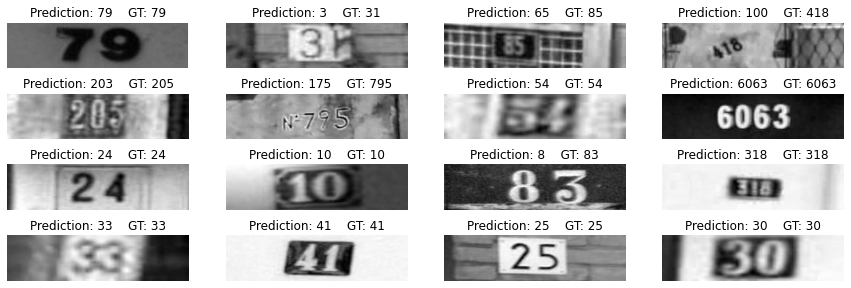

In [212]:
for batch in validation_dataset.take(1):
    pred_texts = decode_Sequence(batch)
    batch_images = batch[0]["image"]
    batch_labels = batch[1]

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(tf.argmax(label, axis=1))).numpy().decode("utf-8").replace("\x01","").replace(EOS,"")
        orig_texts.append(label)   
        
        
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}    GT: {orig_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()        